<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#View-Baumgartner_C-N.pb-file" data-toc-modified-id="View-Baumgartner_C-N.pb-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>View Baumgartner_C-N.pb file</a></span></li><li><span><a href="#Train-Benchmarks" data-toc-modified-id="Train-Benchmarks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Baumgartner_C-N" data-toc-modified-id="Baumgartner_C-N-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baumgartner_C-N</a></span><ul class="toc-item"><li><span><a href="#Set-up-4-domains" data-toc-modified-id="Set-up-4-domains-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Set up 4 domains</a></span></li><li><span><a href="#Create-Dataset" data-toc-modified-id="Create-Dataset-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Create Dataset</a></span></li><li><span><a href="#train-benchmarks-=-bm" data-toc-modified-id="train-benchmarks-=-bm-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>train benchmarks = bm</a></span></li><li><span><a href="#Save-Benchmarks" data-toc-modified-id="Save-Benchmarks-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Save Benchmarks</a></span></li><li><span><a href="#Load-Benchmarks" data-toc-modified-id="Load-Benchmarks-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Load Benchmarks</a></span></li></ul></li></ul></li><li><span><a href="#Plot-all-results-(Imports,-then-start-here)" data-toc-modified-id="Plot-all-results-(Imports,-then-start-here)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot all results (Imports, then start here)</a></span><ul class="toc-item"><li><span><a href="#define-pretraining-datasets" data-toc-modified-id="define-pretraining-datasets-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>define pretraining datasets</a></span></li><li><span><a href="#Load-Benchmarks" data-toc-modified-id="Load-Benchmarks-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Load Benchmarks</a></span></li><li><span><a href="#Produce-graphs" data-toc-modified-id="Produce-graphs-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Produce graphs</a></span><ul class="toc-item"><li><span><a href="#Aniline" data-toc-modified-id="Aniline-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Aniline</a></span></li><li><span><a href="#Benzamide" data-toc-modified-id="Benzamide-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Benzamide</a></span></li><li><span><a href="#phenethylamine" data-toc-modified-id="phenethylamine-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>phenethylamine</a></span></li><li><span><a href="#Morpholine" data-toc-modified-id="Morpholine-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Morpholine</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [1]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import os
#import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob
from IPython.display import clear_output

#summit
import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit import Runner
from summit.strategies import Random, SOBO, MultitoSingleObjective, STBO, MTBO
from summit.benchmarks import SnarBenchmark
import pkg_resources
import pathlib
import random
from summit.strategies import LHS, MTBO


# View Baumgartner_C-N.pb file

In [8]:
pb = '../data/baumgartner_C-N/baumgartner_C-N.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
#df

In [9]:
max(df['outcomes[0].products[0].measurements[0].percentage.value'])

103.16002655029297

In [ ]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

In [10]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]
#df

# Train Benchmarks
https://gosummit.readthedocs.io/en/latest/tutorials/new_benchmarks.html

## Baumgartner_C-N

### Set up 4 domains

We are going to manipulate:
- Ligand (precatalyst is always the same)
- Base
- Solvent
- Temperature
- Reaction time

We will create 4 domains, one for each nucleophile

Objective: Maximise yield

Decision variables

The precatalyst is always the same: https://www.strem.com/catalog/v/46-0308/51/palladium_225931-80-6

The additive is always the same: 4-Chlorotoluene

The ligand changes

In [11]:
# aniline_domain = Domain()
# benzamide_domain = Domain()
# phenethylamine_domain = Domain()
# morpholine_domain = Domain()

# domain_list = [aniline_domain,benzamide_domain,phenethylamine_domain,morpholine_domain]

domain = Domain()

# Decision variables
des_1 = "Catalyst"
domain += CategoricalVariable(
    name='inputs["Catalyst"].components[0].identifiers[0].value',
    description=des_1,
    levels=[
        'cycloPd tBuXPhos 4-Chlorotoluene', 
         'cycloPd EPhos 4-Chlorotoluene', 
         'cycloPd AlPhos 4-Chlorotoluene', 
         'cycloPd tBuBrettPhos 4-Chlorotoluene',
    ],
)


# Decision variables
des_2 = "Base"
domain += CategoricalVariable(
    name='inputs["Base"].components[0].identifiers[0].value',
    description=des_2,
    levels=[
        "TEA",
        "Triethylamine",
        "TMG",
        "BTMG",
        "DBU",
        "MTBD",
        "BTTP",
        "P2Et",
    ],
)

# Decision variables
des_3 = "Solvent"
domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_3,
    levels=[
        "2-MeTHF",
        "DMSO",
    ],
)

des_4 = "Residence time in seconds (s)"
domain += ContinuousVariable(name="outcomes[0].reaction_time.value", description=des_4, bounds=[60, 6000])

des_5 = "Reactor temperature in degrees Celsius (ºC)"
domain += ContinuousVariable(
    name="conditions.temperature.setpoint.value", description=des_5, bounds=[30, 110]
)


# Objectives
des_6 = "Yield"
domain += ContinuousVariable(
    name="outcomes[0].products[0].measurements[0].percentage.value",
    description=des_6,
    bounds=[0, 105],
    is_objective=True,
    maximize=True,
)

In [12]:
domain

Name,Type,Description,Values
"inputs[""Catalyst""].components[0].identifiers[0].value","categorical, input",Catalyst,4 levels
"inputs[""Base""].components[0].identifiers[0].value","categorical, input",Base,8 levels
"inputs[""Solvent""].components[0].identifiers[0].value","categorical, input",Solvent,2 levels
outcomes[0].reaction_time.value,"continuous, input",Residence time in seconds (s),"[60,6000]"
conditions.temperature.setpoint.value,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30,110]"
outcomes[0].products[0].measurements[0].percentage.value,"continuous, maximize objective",Yield,"[0,105]"


### Create Dataset

We need 4 datasets, one for each nucleophile

In [13]:
aniline_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Aniline']
benzamide_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Benzamide']
phenethylamine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Phenethylamine']
morpholine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Morpholine']

#remove nucleophile row
del aniline_df['inputs["Nucleophile"].components[0].identifiers[0].value']
del benzamide_df['inputs["Nucleophile"].components[0].identifiers[0].value']
del phenethylamine_df['inputs["Nucleophile"].components[0].identifiers[0].value']
del morpholine_df['inputs["Nucleophile"].components[0].identifiers[0].value']

In [14]:
# shuffle df
aniline_df = aniline_df.sample(frac=1)
aniline_ds = DataSet.from_df(aniline_df)

benzamide_df = aniline_df.sample(frac=1)
benzamide_ds = DataSet.from_df(benzamide_df)

phenethylamine_df = aniline_df.sample(frac=1)
phenethylamine_ds = DataSet.from_df(phenethylamine_df)

morpholine_df = aniline_df.sample(frac=1)
morpholine_ds = DataSet.from_df(morpholine_df)


### train benchmarks = bm

In [15]:
aniline_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=aniline_ds)
aniline_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.74028683, 1.73236108, 1.68952203, 1.77566385, 1.763767  ]),
 'score_time': array([0.00475907, 0.00500607, 0.00619197, 0.00439334, 0.00456095]),
 'val_r2': array([0.77407567, 0.77721807, 0.81947324, 0.81456258, 0.84715028]),
 'val_neg_root_mean_squared_error': array([-19.62568283, -20.07541275, -16.9094429 , -18.17606544,
        -16.6802597 ])}

In [16]:
benzamide_bm = ExperimentalEmulator(model_name='benzamide_bm', domain=domain, dataset=benzamide_ds)
benzamide_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.86118293, 1.65590525, 1.80755401, 2.04780483, 1.85176706]),
 'score_time': array([0.0046699 , 0.00462103, 0.00528693, 0.00504827, 0.0044899 ]),
 'val_r2': array([0.89176387, 0.75922942, 0.82704495, 0.72810325, 0.81114572]),
 'val_neg_root_mean_squared_error': array([-13.49734402, -20.80726624, -16.49158859, -21.95610237,
        -18.9395504 ])}

In [17]:
phenethylamine_bm = ExperimentalEmulator(model_name='phenethylamine_bm', domain=domain, dataset=phenethylamine_ds)
phenethylamine_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.90701294, 1.76540327, 1.96894789, 1.71695399, 1.87869   ]),
 'score_time': array([0.00562   , 0.00462389, 0.00469184, 0.00447106, 0.00507092]),
 'val_r2': array([0.83436159, 0.79509993, 0.7750674 , 0.79510296, 0.70122347]),
 'val_neg_root_mean_squared_error': array([-17.72636795, -18.43821526, -19.26811981, -18.78307533,
        -21.21933556])}

In [18]:
morpholine_bm = ExperimentalEmulator(model_name='morpholine_bm', domain=domain, dataset=morpholine_ds)
morpholine_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.76603508, 1.94745207, 1.85257912, 1.70807004, 2.13356113]),
 'score_time': array([0.0056901 , 0.00553298, 0.00485706, 0.00440598, 0.00611377]),
 'val_r2': array([0.82840877, 0.80480995, 0.81387507, 0.78253374, 0.74652789]),
 'val_neg_root_mean_squared_error': array([-17.55539703, -18.84023666, -17.57561684, -18.52482224,
        -20.77902031])}

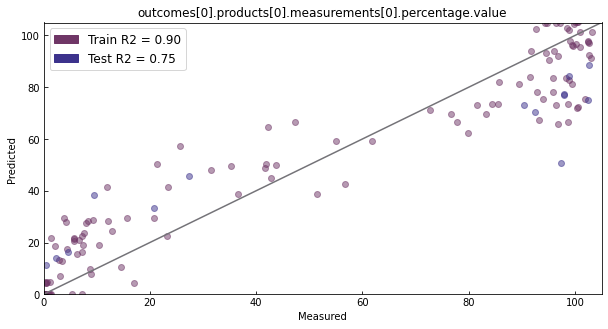

In [19]:
#Parity plots
fig, ax = morpholine_bm.parity_plot(include_test=True)

In [20]:
#Test out a set of conditions on the benchmark
conditions = [["cycloPd EPhos 4-Chlorotoluene", 'BTMG', '2-MeTHF', 1324, 65.0]]
conditions = DataSet(conditions, columns=[v.name for v in domain.input_variables])
morpholine_bm.run_experiments(conditions)

,"inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value",outcomes[0].reaction_time.value,conditions.temperature.setpoint.value,outcomes[0].products[0].measurements[0].percentage.value,computation_t,experiment_t,strategy
0,cycloPd EPhos 4-Chlorotoluene,BTMG,2-MeTHF,1324,65.0,59.232277,0.0,0.029717,NaN


### Save Benchmarks

In [21]:
# Save it
aniline_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/aniline_emulator")

benzamide_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/benzamide_emulator")

phenethylamine_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/phenethylamine_emulator")

morpholine_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/morpholine_emulator")

### Load Benchmarks

In [22]:
# Load them
aniline_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/aniline_emulator")
benzamide_bm = ExperimentalEmulator.load(model_name="benzamide_bm", save_dir="../data/baumgartner_C-N/benzamide_emulator")
phenethylamine_bm = ExperimentalEmulator.load(model_name="phenethylamine_bm", save_dir="../data/baumgartner_C-N/phenethylamine_emulator")
morpholine_bm = ExperimentalEmulator.load(model_name="morpholine_bm", save_dir="../data/baumgartner_C-N/morpholine_emulator")

In [23]:
#add meta column

aniline_ds[("task", "METADATA")] = 0
benzamide_ds[("task", "METADATA")] = 0
phenethylamine_ds[("task", "METADATA")] = 0
morpholine_ds[("task", "METADATA")] = 0

# Plot all results (Imports, then start here) 

In [99]:
class Nucleophile():
    
    def __init__(self, nucleophile, exp, N_REPEATS=10, MAX_ITERATIONS=20):
        self.nucleophile = nucleophile #string with the name of the nucleophile
        self.exp = exp
        self.N_REPEATS = N_REPEATS
        self.MAX_ITERATIONS = MAX_ITERATIONS
        
    def run_random(self, random_state=np.random.RandomState(3)):
        self.exp.reset()
        strategy = Random(self.exp.domain, 
                        random_state=random_state)
        r = summit.Runner(strategy=strategy, 
                          experiment=self.exp, 
                          max_iterations=self.MAX_ITERATIONS)
        r.run()
        return r

    def run_sobo(self, categorical_method="one-hot"):
        self.exp.reset()
        strategy = SOBO(self.exp.domain, 
                        categorical_method=categorical_method)
        r = summit.Runner(strategy=strategy, 
                          experiment=self.exp, 
                          max_iterations=self.MAX_ITERATIONS)
        r.run()
        return r

    def run_mtbo(self, pt_data, task=1):
            self.exp.reset()
            strategy = MTBO(self.exp.domain, 
                            pretraining_data=pt_data,
                            categorical_method="one-hot",
                            task=task)
            r = summit.Runner(strategy=strategy,
                              experiment=self.exp, 
                              max_iterations=self.MAX_ITERATIONS)
            r.run()
            return r


    def make_average_plot(self, results: [summit.Runner], ax, label=None, color=None):
        objective = results[0].experiment.domain.output_variables[0].name
        yields = [r.experiment.data[objective] for r in results]
        yields = np.array(yields)
        mean_yield = np.mean(yields, axis=0)
        std_yield = np.std(yields, axis=0)
        x = np.arange(0, len(mean_yield), 1).astype(int)
        ax.plot(x, mean_yield, label=label, linewidth=2, color=color)
        ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

    def plot_figure(self, pt_name):
        #pt_name: name of nucleophile used for pretraining
        
        random_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_random_{i}.json") for i in range(10)]
        sobo_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_SOBO_{i}.json") for i in range(10)]
        mtbo10_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_10_MTBO_{i}.json") for i in range(10)]
        mtbo50_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_50_MTBO_{i}.json") for i in range(10)]
        
        fig, ax = self.make_comparison_plot(
            dict(results=random_results, label="Random", color = 'blue'),
            dict(results=sobo_results, label="SOBO", color = 'orange'),
            dict(results=mtbo10_results, label="MTBO, n=10", color = 'purple'),
            dict(results=mtbo50_results,label="MTBO, n=50", color = 'green'),
            )
        fig.suptitle(self.nucleophile+' trained on '+ pt_name, fontsize=16)
        fig.savefig(f"../figures/baumgartner_CN/{self.nucleophile}_pt_on_{pt_name}.png", bbox_inches='tight', dpi=300)
        
    def random_strategy(self):
        #Random
        for i in range(self.N_REPEATS):
            print(f"Repeat {i}")
            result = self.run_random()
            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_random_{i}.json")
            clear_output(wait=True)
            
    def SOBO_strategy(self):
        #Single-Objective Bayesian Optimization
        for i in range(self.N_REPEATS):
            print(f"Repeat {i}")
            result = self.run_sobo()
            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_SOBO_{i}.json")
            clear_output(wait=True)
            
    def MTBO_strategy(self, pt, pt_name, pt_samples):
    #pt = pretraining dataset
    #pt_name = string of the nucleophile used for pretraining
    #pt_samples = number of pretraining datapoints from pt, either 10 or 50
    #Multi-Task Bayesian Optimization
        for i in range(self.N_REPEATS):
            #randomly select pt_samples sample indices for pretraining
            random_indices = random.sample(range(0, len(pt)), pt_samples)
            random_samples = pt.loc[random_indices]

            
            print(f"Repeat {i}")
            
            #To avoid NotPSDError (which occurs when the model picks points too close to each other)
            # simply run the model again. It's unlikely to fail twice in a row
            try:
                result = self.run_mtbo(random_samples)
            except RuntimeError:
                try:
                    result = self.run_mtbo(random_samples)
                except RuntimeError:
                    result = self.run_mtbo(random_samples)
                

            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_{pt_samples}_MTBO_{i}.json")
            clear_output(wait=True)


    def make_comparison_plot(self, *args):
        fig, ax = plt.subplots(1)
        for arg in args:
            self.make_average_plot(arg['results'], ax, label=arg["label"], color=arg["color"])
        fontdict = fontdict={"size":12}
        ax.legend(loc = "lower right", prop=fontdict)
        ax.set_xlim(0,20)
        ax.set_xticks(np.arange(0, 20, 2).astype(int))
        ax.set_ylabel('Yield', fontdict=fontdict)
        ax.set_xlabel('Reactions', fontdict=fontdict)
        ax.tick_params(direction='in')
        return fig, ax 
    

## define pretraining datasets

In [12]:
pb = '../data/baumgartner_C-N/baumgartner_C-N.pb'
data = message_helpers.load_message(pb, dataset_pb2.Dataset)
valid_output = validations.validate_message(data)
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]

aniline_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Aniline']
benzamide_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Benzamide']
phenethylamine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Phenethylamine']
morpholine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Morpholine']

aniline_df.reset_index(inplace=True)
benzamide_df.reset_index(inplace=True)
phenethylamine_df.reset_index(inplace=True)
morpholine_df.reset_index(inplace=True)


aniline_ds = DataSet.from_df(aniline_df)
benzamide_ds = DataSet.from_df(benzamide_df)
phenethylamine_ds = DataSet.from_df(phenethylamine_df)
morpholine_ds = DataSet.from_df(morpholine_df)

#add meta column
aniline_ds[("task", "METADATA")] = 0
benzamide_ds[("task", "METADATA")] = 0
phenethylamine_ds[("task", "METADATA")] = 0
morpholine_ds[("task", "METADATA")] = 0


## Load Benchmarks

In [13]:
# Load them
aniline_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/aniline_emulator")
benzamide_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/benzamide_emulator")
phenethylamine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/phenethylamine_emulator")
morpholine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/morpholine_emulator")

## Produce graphs

### Aniline

In [77]:
aniline = Nucleophile('aniline', aniline_bm)

In [15]:
aniline.random_strategy()

Repeat 9


In [16]:
aniline.SOBO_strategy()

Repeat 9


In [17]:
aniline.MTBO_strategy(benzamide_ds, 'benzamide', 10)

Repeat 9


In [21]:
aniline.MTBO_strategy(benzamide_ds, 'benzamide', 50)

Repeat 9


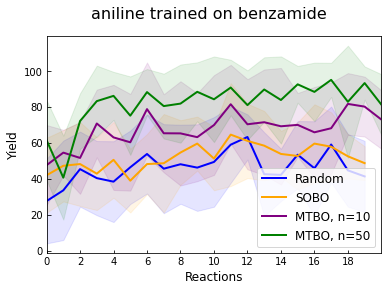

In [25]:
aniline.plot_figure('benzamide')

In [26]:
aniline.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 10)

Repeat 9


In [78]:
aniline.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 50)

Repeat 9


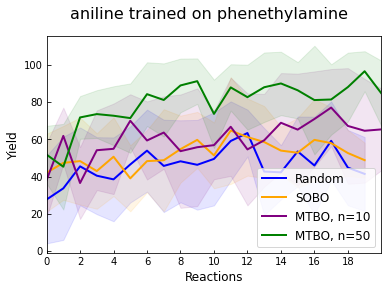

In [79]:
aniline.plot_figure('phenethylamine')

In [54]:
aniline.MTBO_strategy(morpholine_ds, 'morpholine', 10)

Repeat 9


In [80]:
aniline.MTBO_strategy(morpholine_ds, 'morpholine', 50)

Repeat 9


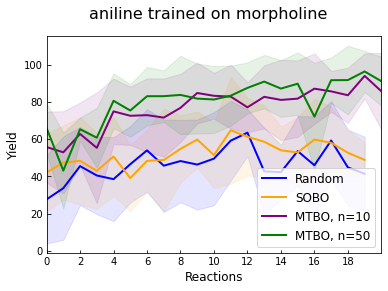

In [81]:
aniline.plot_figure('morpholine')

### Benzamide

In [100]:
benzamide = Nucleophile('benzamide', benzamide_bm)

In [82]:
benzamide.random_strategy()
benzamide.SOBO_strategy()

Repeat 9


In [83]:
benzamide.MTBO_strategy(aniline_ds, 'aniline', 10)

Repeat 9


In [84]:
benzamide.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 10)

Repeat 9


In [86]:
benzamide.MTBO_strategy(morpholine_ds, 'morpholine', 10)

Repeat 9


In [109]:
benzamide.MTBO_strategy(aniline_ds, 'aniline', 50)

Repeat 9


In [110]:
benzamide.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 50)

Repeat 9


In [114]:
benzamide.MTBO_strategy(morpholine_ds, 'morpholine', 50)

Repeat 9


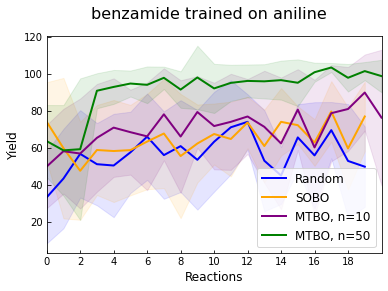

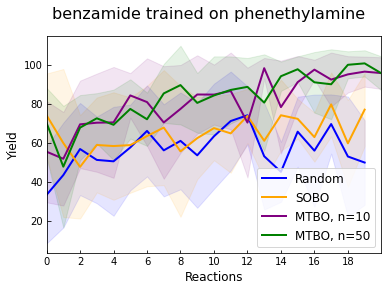

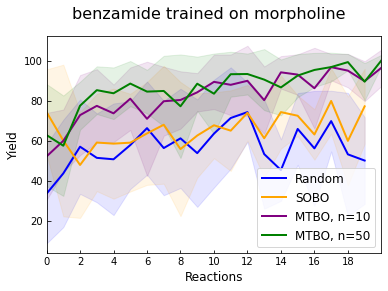

In [115]:
benzamide.plot_figure('aniline')
benzamide.plot_figure('phenethylamine')
benzamide.plot_figure('morpholine')

### phenethylamine

In [92]:
phenethylamine = Nucleophile('phenethylamine', phenethylamine_bm)
phenethylamine.random_strategy()
phenethylamine.SOBO_strategy()

Repeat 9


In [93]:
phenethylamine.MTBO_strategy(aniline_ds, 'aniline', 10)
phenethylamine.MTBO_strategy(benzamide_ds, 'benzamide', 10)
phenethylamine.MTBO_strategy(morpholine_ds, 'morpholine', 10)

Repeat 9


In [94]:
phenethylamine.MTBO_strategy(aniline_ds, 'aniline', 50)

Repeat 9


In [104]:
phenethylamine.MTBO_strategy(benzamide_ds, 'benzamide', 50)

Repeat 9


In [96]:
phenethylamine.MTBO_strategy(morpholine_ds, 'morpholine', 50)

Repeat 9


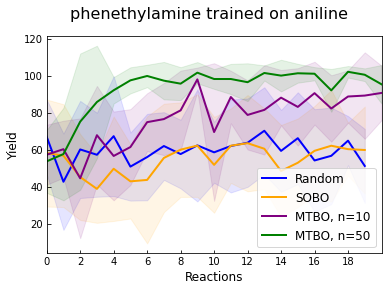

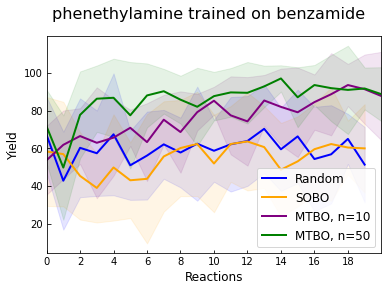

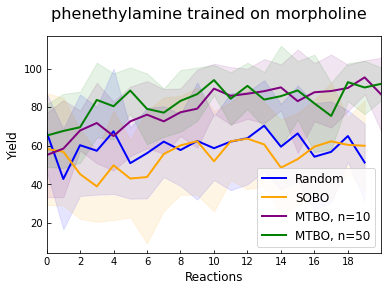

In [105]:
phenethylamine.plot_figure('aniline')
phenethylamine.plot_figure('benzamide')
phenethylamine.plot_figure('morpholine')

### Morpholine

In [116]:
morpholine = Nucleophile('morpholine', morpholine_bm)
morpholine.random_strategy()
morpholine.SOBO_strategy()

Repeat 9


In [117]:
morpholine.MTBO_strategy(aniline_ds, 'aniline', 10)
morpholine.MTBO_strategy(benzamide_ds, 'benzamide', 10)
morpholine.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 10)

Repeat 9


In [118]:
morpholine.MTBO_strategy(aniline_ds, 'aniline', 50)

Repeat 9


In [119]:
morpholine.MTBO_strategy(benzamide_ds, 'benzamide', 50)

Repeat 9


In [120]:
morpholine.MTBO_strategy(phenethylamine_ds, 'phenethylamine', 50)

Repeat 9


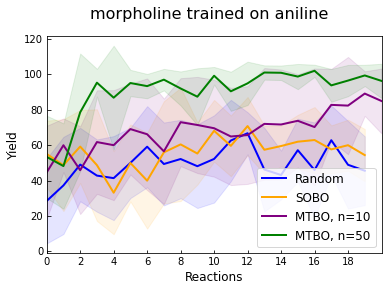

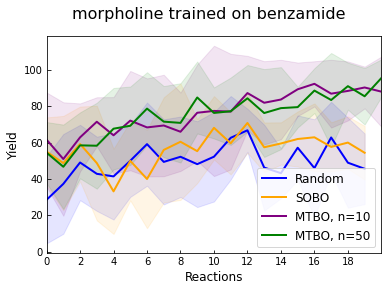

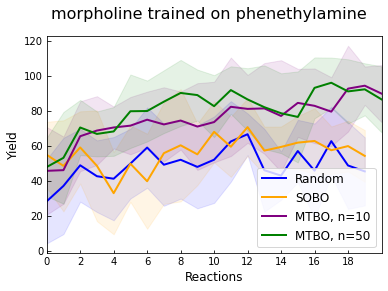

In [121]:
morpholine.plot_figure('aniline')
morpholine.plot_figure('benzamide')
morpholine.plot_figure('phenethylamine')